In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import sparse

import torch

import schrodingerUtils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
# Discretize the dimensions to simplify the following simulations
# More points gives a better simulation but will require more computation

NUM_DIMENSIONS = 2
POINTS_PER_DIMENSION = 200

X, Y = schrodingerUtils.physics.createNDimensionalMeshGrid(NUM_DIMENSIONS, POINTS_PER_DIMENSION, [-3,3])

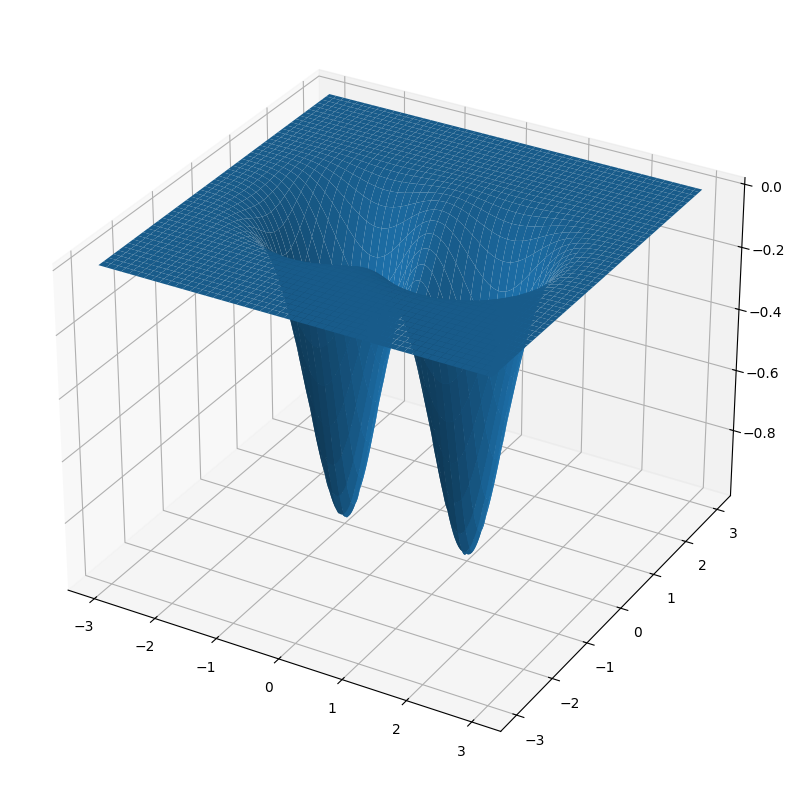

In [106]:
# Potential is a function over the entire space that determines the potential energy of a particle at that position
# Negative potentials will act as attractors, and positive potentials will act as repellors

def gaussian(xPos, xWidth, yPos, yWidth):
    return lambda x,y: np.exp(-(x-xPos)**2 / (2*xWidth**2)) * np.exp(-(y-yPos)**2 / (2*yWidth**2))

def potential(x,y):
    STD = 0.5
    leftGaussian = gaussian(-1,STD,0,STD)
    rightGaussian = gaussian(1,STD,0,STD)
    return - (leftGaussian(x,y) + rightGaussian(x,y))

# def potential(x,y):
#     g = gaussian(0,1.5,0,1.5)
#     return - g(x,y)

V = potential(X,Y)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# ax.set_zlim((0,1.1))
schrodingerUtils.display.plotSurface(X,Y,V, ax=ax)

In [107]:
T = schrodingerUtils.physics.getKineticSchrodingerTerm(NUM_DIMENSIONS, POINTS_PER_DIMENSION)
U = sparse.diags(V.reshape(POINTS_PER_DIMENSION**2), (0))

H = T+U

schrodingerSolver = schrodingerUtils.physics.TorchSchrodingerSolver(H, POINTS_PER_DIMENSION)

In [108]:
numEigenstates = 30
schrodingerSolver.solveEigenstates(numEigenstates=numEigenstates)

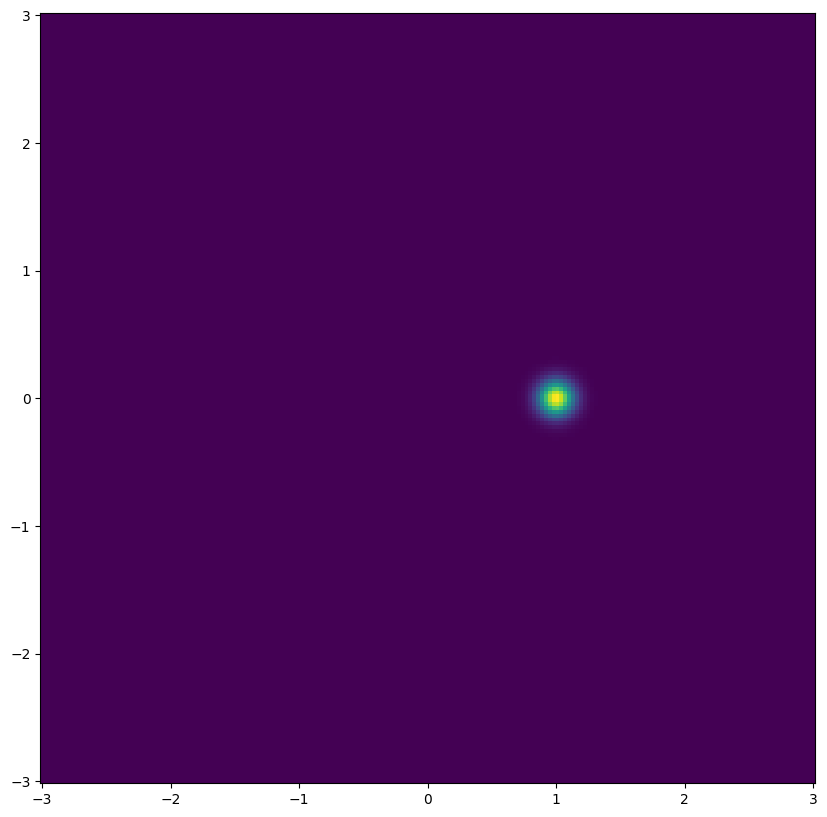

In [104]:
targetIndex = 0
eigenvalue, eigenvector = schrodingerSolver.getEigenstate(targetIndex)
schrodingerUtils.display.plotColormesh(X, Y, eigenvector**2)

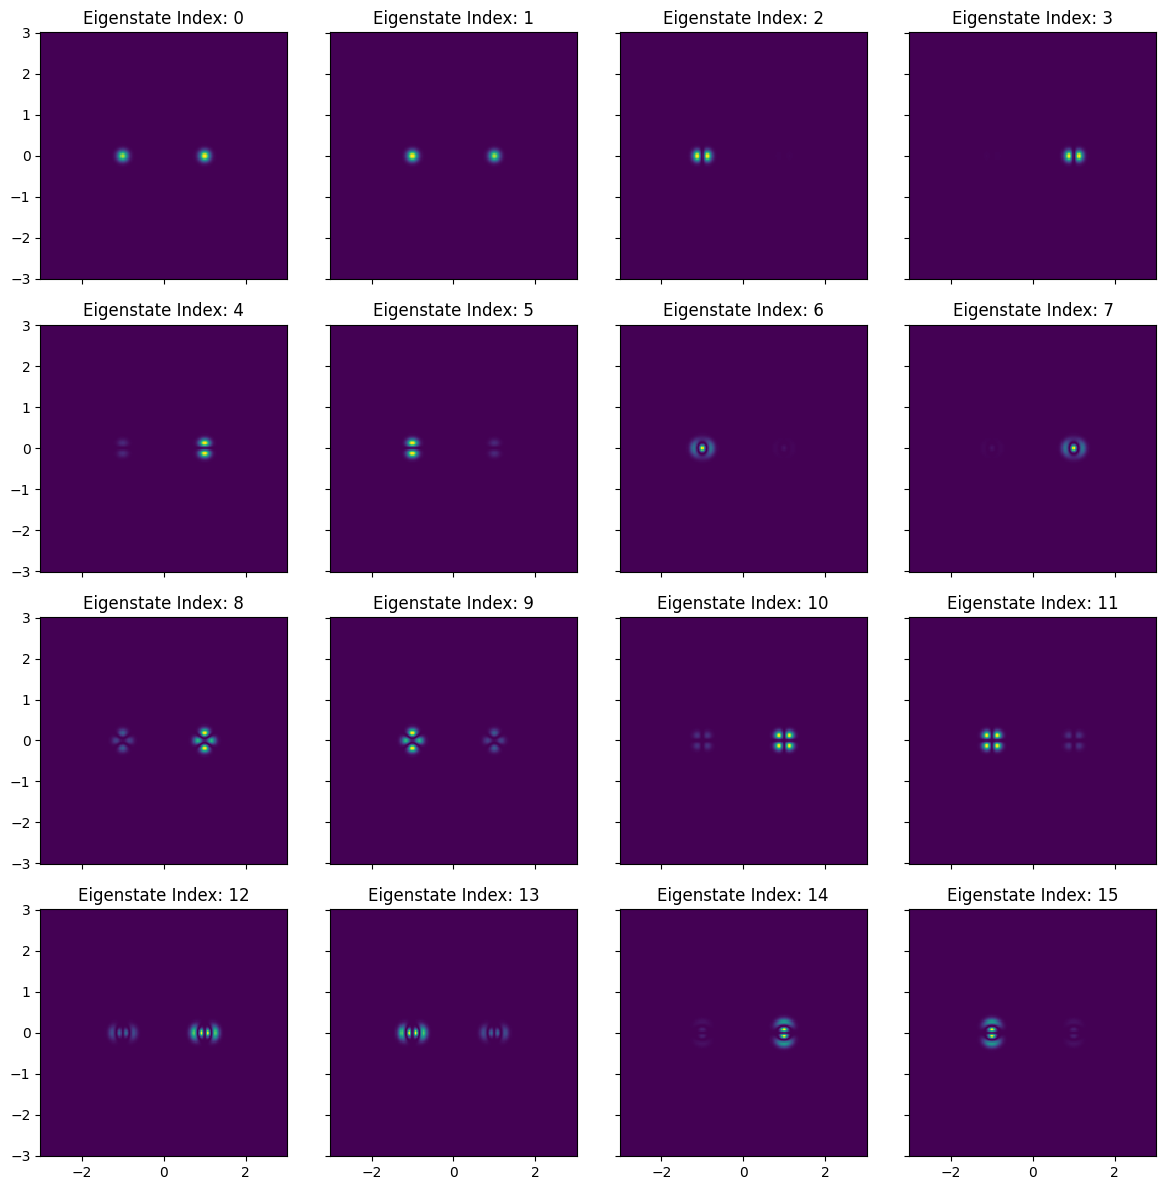

In [112]:
axisDim = 3

# numRows = 4
# numCols = numEigenstates//numRows
# numCols = 4
# numRows = numEigenstates//numCols
numCols = 4
numRows = 4


fig, axes = plt.subplots(ncols=numCols, nrows=numRows, sharex=True, sharey=True, figsize=(numCols*axisDim,numRows*axisDim))

axes = np.ravel(axes)
for i in range(len(axes)):
    targetAxis = axes[i]
    if i > numEigenstates:
        targetAxis.axis("off")
        continue

    targetAxis.set_title(f"Eigenstate Index: {i}")
    targetAxis.set_aspect("equal")
    eigenvalue, eigenvector = schrodingerSolver.getEigenstate(i)
    schrodingerUtils.display.plotColormesh(X, Y, eigenvector**2, ax=targetAxis, showPlot=False)
plt.tight_layout()
plt.show()